In [2]:
%matplotlib inline

from keras.datasets import mnist
from brian2 import *
import brian2.numpy_ as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import classification_report
import seaborn as sns
from tqdm import tqdm
import os
import gc

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train / 4
X_test = X_test / 4

X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

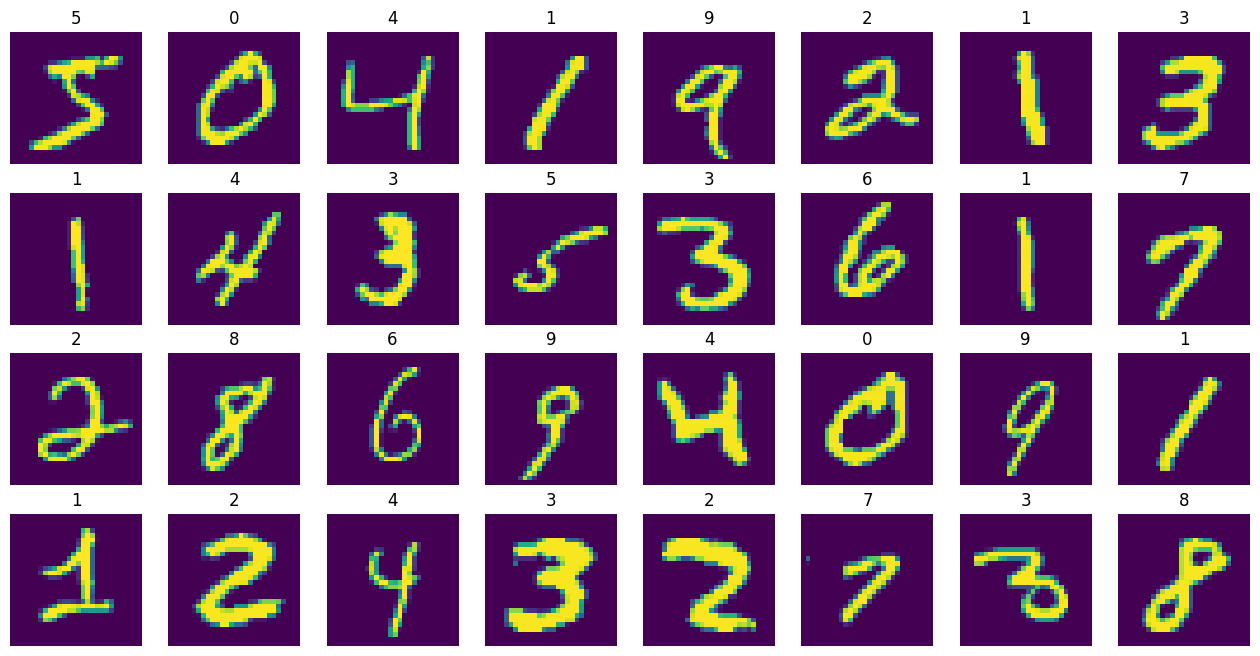

In [4]:
plt.figure(figsize = (16, 8))
for img in range(32):
    plt.subplot(4, 8, 1+img)
    plt.title(y_train[img])
    plt.imshow(X_train[img])
    plt.axis('off')

In [5]:
n_input = 28*28
n_e = 700
n_i = n_e

v_rest_e = -60.*mV
v_reset_e = -65.*mV
v_thresh_e = -52.*mV

v_rest_i = -60.*mV
v_reset_i = -45.*mV
v_thresh_i = -40.*mV

taupre = 20.*ms
taupost = taupre
gmax = .05
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

In [6]:
stdp = '''
w : 1
lr : 1 (shared)
dApre/dt = -Apre / taupre : 1 (event-driven)
dApost/dt = -Apost / taupost : 1 (event-driven)
'''
pre = '''
ge += w
Apre += dApost
w = clip(w + lr*Apost, 0, gmax)
'''
post = '''
Apost += dApost
w = clip(w + lr*Apre, 0, gmax)
'''

In [7]:
class Model():
    def __init__(self, debug = True):
        app = {}

        app['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')

        neuron_e = '''
            dv/dt = (ge * (0 * mV - v) + gi * (-100 * mV - v) + (v_rest_e - v)) / (100 * ms) : volt
            dge/dt = -ge / (5 * ms) : 1
            dgi/dt = -gi / (10 * ms) : 1
        '''

        app['EG'] = NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', refractory= 5 * ms, reset = 'v=v_reset_e', method='euler', name = 'EG')
        app['EG'].v = v_rest_e - 20.*mV
        if(debug):
            app['ESP'] = SpikeMonitor(app['EG'], name='ESP')
            app['ESM'] = StateMonitor(app['EG'], ['v'], record=True, name='ESM')
            app['ERM'] = PopulationRateMonitor(app['EG'], name='ERM')

        neuron_i = '''
            dv/dt = (ge * (0 * mV - v) + (v_rest_i - v)) / (10 * ms) : volt
            dge/dt = -ge / (5 * ms) : 1
        '''

        app['IG'] = NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=2*ms, reset='v=v_reset_i', method='euler', name='IG')
        app['IG'].v = v_rest_i - 20.*mV
        if(debug):
            app['ISP'] = SpikeMonitor(app['IG'], name='ISP')
            app['ISM'] = StateMonitor(app['IG'], ['v'], record=True, name='ISM')
            app['IRM'] = PopulationRateMonitor(app['IG'], name='IRM')

        app['S1'] = Synapses(app['PG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S1')
        app['S1'].connect()
        app['S1'].w = 'rand()*gmax'
        app['S1'].lr = 1
        if(debug):
            app['S1M'] = StateMonitor(app['S1'], ['w', 'Apre', 'Apost'], record=app['S1'][380, :4], name='S1M')

        app['S2'] = Synapses(app['EG'], app['IG'], 'w: 1', on_pre='ge += w', name='S2')
        app['S2'].connect(j='i')
        app['S2'].delay = 'rand()*10*ms'
        app['S2'].w = 3

        app['S3'] = Synapses(app['IG'], app['EG'], 'w: 1', on_pre='gi += w', name = 'S3')
        app['S3'].connect(condition = 'i != j')
        app['S3'].delay = 'rand()*5 * ms'
        app['S3'].w = .03

        self.net = Network(app.values())
        self.net.run(0 * second)
    def __getitem__(self, key):
        return self.net[key]
    
    def train(self, X, epoch=1):
        self.net['S1'].lr = 1
        for ep in range(epoch):
            print(f"Epoch {ep + 1}/{epoch}")
            for idx in tqdm(range(len(X)), desc=f"Training samples (Epoch {ep + 1})"):
                self.net['PG'].rates = X[idx].ravel() * Hz
                self.net.run(0.35 * second)
    
                self.net['PG'].rates = np.zeros(n_input) * Hz
                self.net.run(0.15 * second)

    def evaluate(self, X):
        self.net['S1'].lr = 0

        features = []
        for idx in range(len(X)):
            mon = SpikeMonitor(self.net['EG'], name = 'RM')
            self.net.add(mon)

            self.net['PG'].rates = X[idx].ravel()*Hz
            self.net.run(0.35*second)

            features.append(np.array(mon.count, dtype=int8))

            self.net['PG'].rates = np.zeros(n_input)*Hz
            self.net.run(0.15*second)
            self.net.remove(self.net['RM'])
        return features

def evaluate_model(model, X_test, y_test, n_samples=None):
    """
    Evaluate the model and compute performance metrics
    
    Args:
        model: Your trained SNN model
        X_test: Test images
        y_test: Test labels
        n_samples: Number of samples to evaluate (None for all)
    """
    if n_samples is None:
        n_samples = len(X_test)
    
    # Get predictions
    features = model.evaluate(X_test[:n_samples])
    y_pred = np.argmax(features, axis=1)
    y_true = y_test[:n_samples]
    
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true, y_pred)
    
    # Print metrics
    print(f"\nEvaluation Metrics for {n_samples} test samples:")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    return accuracy, conf_mat

Epoch 1/2


Training samples (Epoch 1): 100%|███████████| 30/30 [00:37<00:00,  1.25s/it]


Epoch 2/2


Training samples (Epoch 2): 100%|███████████| 30/30 [00:36<00:00,  1.23s/it]


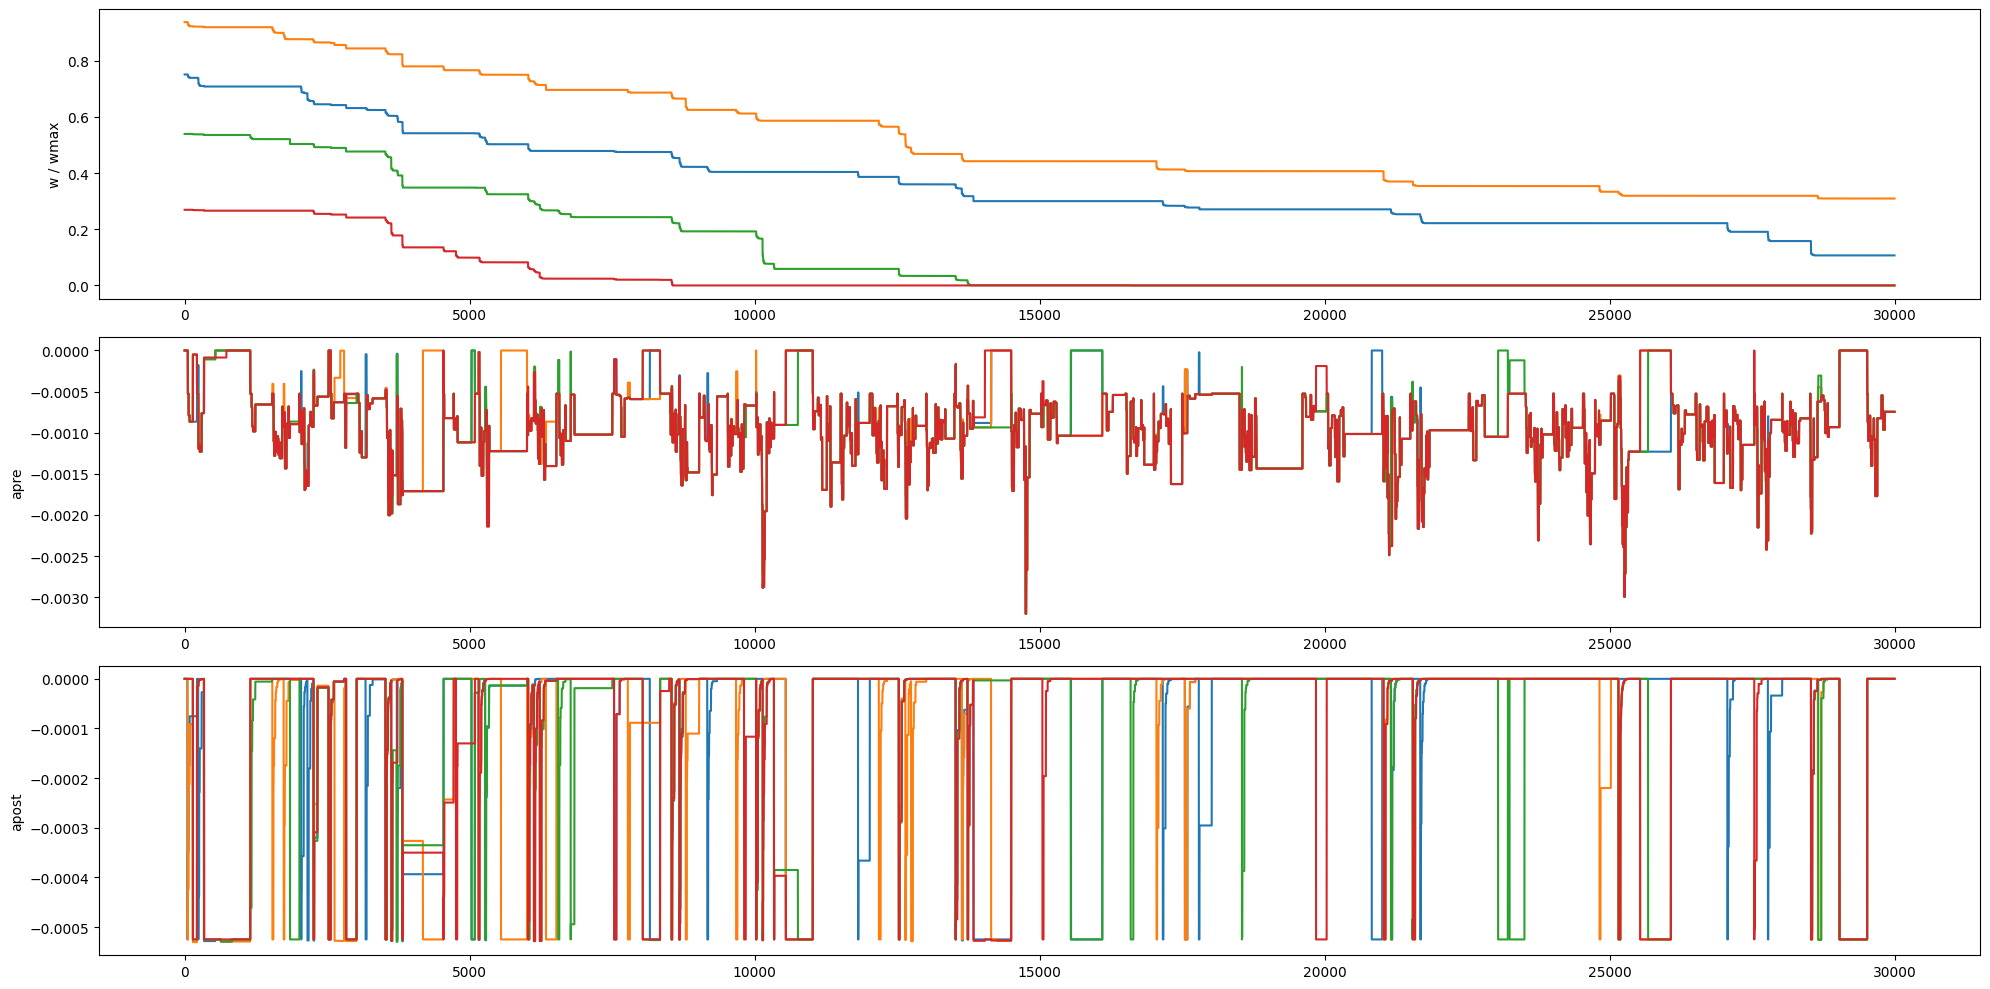

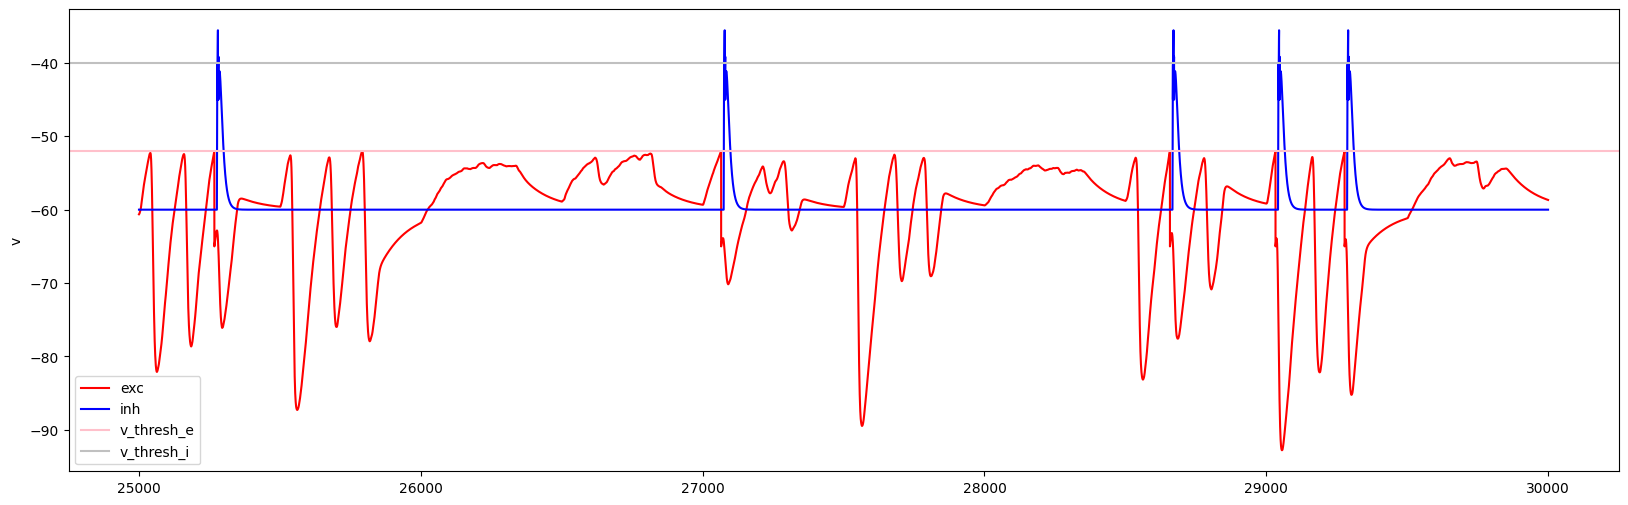

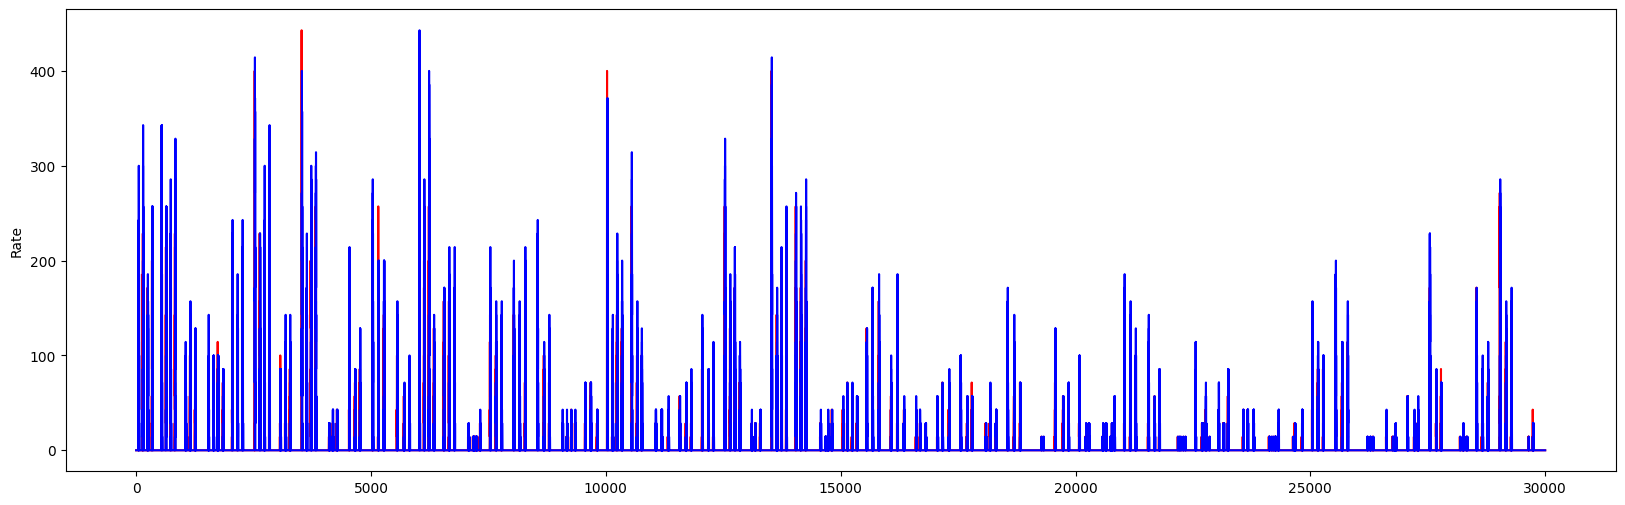

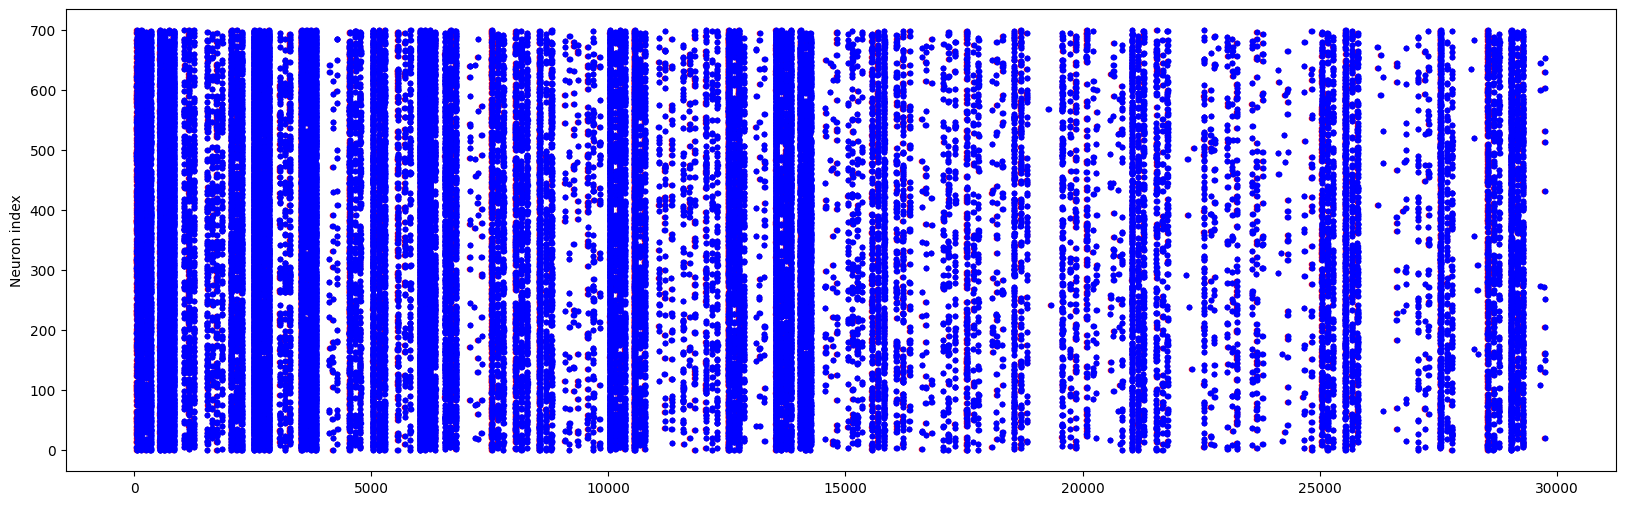

In [8]:
def plot_w(S1M):
    plt.rcParams["figure.figsize"] = (20,10)
    subplot(311)
    plot(S1M.t/ms, S1M.w.T/gmax)
    ylabel('w / wmax')
    subplot(312)
    plot(S1M.t/ms, S1M.Apre.T)
    ylabel('apre')
    subplot(313)
    plot(S1M.t/ms, S1M.Apost.T)
    ylabel('apost')
    tight_layout()
    show();
    
def plot_v(ESM, ISM, neuron=13):
    plt.rcParams["figure.figsize"] = (20,6)
    cnt = -50000 # tail
    plot(ESM.t[cnt:]/ms, ESM.v[neuron][cnt:]/mV, label='exc', color='r')
    plot(ISM.t[cnt:]/ms, ISM.v[neuron][cnt:]/mV, label='inh', color='b')
    plt.axhline(y=v_thresh_e/mV, color='pink', label='v_thresh_e')
    plt.axhline(y=v_thresh_i/mV, color='silver', label='v_thresh_i')
    legend()
    ylabel('v')
    show();
    
def plot_rates(ERM, IRM):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ERM.t/ms, ERM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='r')
    plot(IRM.t/ms, IRM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='b')
    ylabel('Rate')
    show();
    
def plot_spikes(ESP, ISP):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ESP.t/ms, ESP.i, '.r')
    plot(ISP.t/ms, ISP.i, '.b')
    ylabel('Neuron index')
    show();

def test0(train_items=30):
    '''
    STDP visualisation
    '''
    seed(0)
    
    global model 
    model = Model(debug=True)
    model.train(X_train[:train_items], epoch=2)
    
    plot_w(model['S1M'])
    plot_v(model['ESM'], model['ISM'])
    plot_rates(model['ERM'], model['IRM'])
    plot_spikes(model['ESP'], model['ISP'])
    
test0()

In [ ]:
# Get feature dimension while immediately freeing memory
with np.errstate(divide='ignore', invalid='ignore'):  # Suppress potential warnings
    first_feat = np.asarray(model.evaluate(X_train[0:1]))
    feature_dim = np.prod(first_feat.shape)
    del first_feat
    gc.collect()

# Memory-efficient feature extraction
def extract_features(model, data, num_samples, dtype=np.float16):  # Use float16
    features = np.memmap('temp.dat', dtype=dtype, mode='w+', 
                        shape=(num_samples, feature_dim))
    
    for i in range(num_samples):
        # Process one sample at time with garbage collection
        sample = data[i:i+1]
        feat = np.asarray(model.evaluate(sample)).astype(dtype).ravel()
        features[i] = feat
        
        # Aggressive cleanup
        del sample, feat
        if i % 10 == 0:
            gc.collect()
    
    features.flush()
    return features

# Train features
print("Extracting train features...")
train_features = extract_features(model, X_train, 1000)
del X_train  # Free original data if possible
gc.collect()

# Test features
print("Extracting test features...")
test_features = extract_features(model, X_test, 200)
del X_test, model  # Remove model and data from memory
gc.collect()

# Use reduced-precision classifier training
print("Training classifier...")
clf = RandomForestClassifier(
    n_estimators=30,  # Slightly fewer trees
    max_depth=2,
    max_features='sqrt',
    n_jobs=1,  # Single job to avoid memory duplication
    random_state=42,
    bootstrap=False  # Disable bootstrapping to save memory
)

# Convert to float32 for training (smaller than float64)
clf.fit(train_features.astype(np.float32), y_train[:1000].ravel())

# Cleanup before prediction
del train_features
gc.collect()

# Memory-efficient prediction
print("Evaluating classifier...")
y_pred = []
for i in range(0, 200, 10):  # Process in chunks
    chunk = test_features[i:i+10].astype(np.float32)
    y_pred.extend(clf.predict(chunk))
    del chunk
    gc.collect()

# Final evaluation
y_true = y_test[:200]
print(f"\nAccuracy: {accuracy_score(y_true, y_pred)*100:.1f}%")
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Cleanup temporary files
del test_features
gc.collect()
os.remove('temp.dat')

Extracting train features...
